# Project Topic

This project is from the Kaggle competetion "I’m Something of a Painter Myself".  The goal is described below, taken from the competition site:

>A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.
>
>The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.
>
>Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

I will do so using Keras and tensorflow.  I will also build out the components.

In [187]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import gc

import tensorflow as tf
from keras import backend as K

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa

#  Data

In [188]:
dir_monet = "../Week 5 Project/data/monet_jpg/"
dir_photo = "../Week 5 Project/data/photo_jpg/"
files_monet = os.listdir(dir_monet)
files_photo = os.listdir(dir_photo)

n1 = len(files_monet)
n2 = len(files_photo)

In [189]:
print("Number of Monet images = ", n1)
print("Number of Landscape images = ", n2)

Number of Monet images =  300
Number of Landscape images =  7038


In [190]:
# Parameters for the notebook

starting_epoch = 0
number_of_epochs = 5 
batch_size = 1 
adam_learning_rate = 0.0001
adam_decay_1 = 0.5 
adam_decay_2 = 0.999 
starting_decay_epoch = 3 
                 

### Functions 

`convert_image_size` is the function to convert normalized image to original scale. `plot_photo` visualize 36 images. `plot_OneLine` plots 6 images in one line. 

In [191]:
# This converts a normalized image back to its normal size
def convert_image_size(image):
    
    new_image = ((np.array(image) + 1)*127.5).astype(int)
    new_image[new_image > 255] = 255
    new_image[new_image < 0] = 0
    
    new_image = new_image.astype(np.uint8)
    
    return new_image

In [192]:
def plot_photo(image):
    
    img2 = ((np.array(image) + 1)*127.5).astype(int)
    img2[img2 > 255] = 255
    img2[img2 < 0] = 0

    
    fig, ax = plt.subplots(6,6, figsize = (15,15))
    
    N = 36
    for k in range(N):
        i =  int(k/6)
        j = k % 6
    
        ax[i,j].imshow(img2[k])
        ax[i,j].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    

def plot_OneLine(image, title, rescale = False):
    
    img2 = ((np.array(image) + 1)*127.5).astype(int)
    img2[img2 > 255] = 255
    img2[img2 < 0] = 0

    
    fig, ax = plt.subplots(1,6, figsize = (15,2.5))
    
    N = 6
    for k in range(N):
    
        ax[k].imshow(img2[k])
        ax[k].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
        
    
    ax[0].set_title(title)

### Reading images

In [193]:
n2 = 100

In [194]:
M_data = np.zeros((n1,256,256,3)).astype(np.uint8)
F_data = np.zeros((n2,256,256,3)).astype(np.uint8)

In [195]:
for i in range(n1):
    M_data[i] = cv2.cvtColor(cv2.imread(dir_monet + files_monet[i]), cv2.COLOR_BGR2RGB)
    
for i in range(n2):
    F_data[i] = cv2.cvtColor(cv2.imread(dir_photo + files_photo[i]), cv2.COLOR_BGR2RGB)

Images are normalized by following code.

In [196]:
M_data = M_data/(255/2) - 1
F_data = F_data/(255/2) - 1

In [197]:
real_A = M_data[0:36]
real_B = F_data[0:36]

**Monet images**

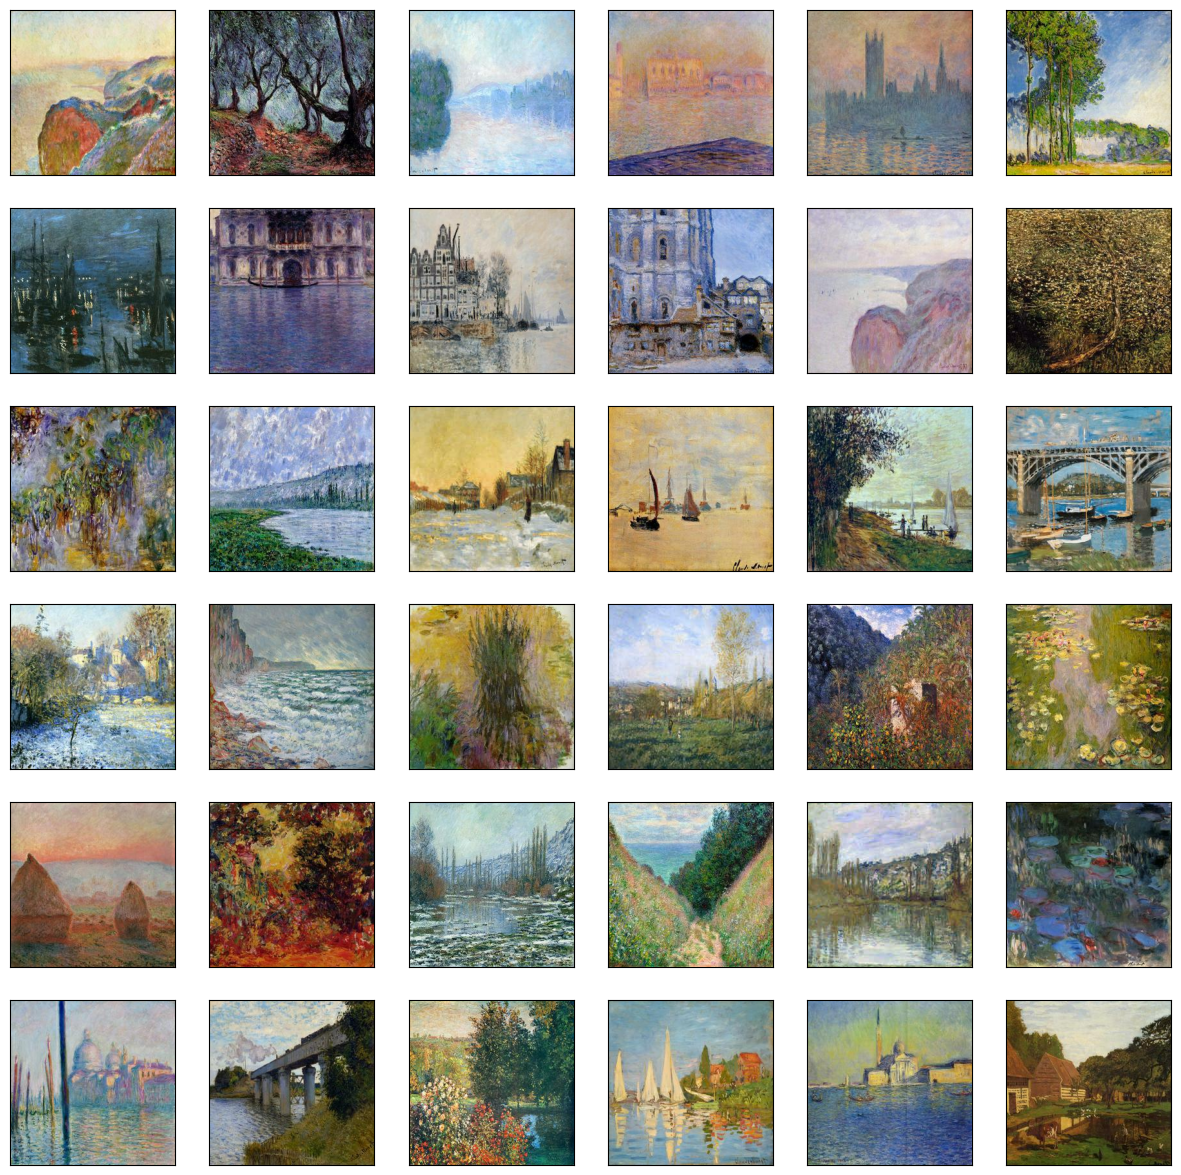

In [198]:
plot_photo(M_data)

**Landscape images**

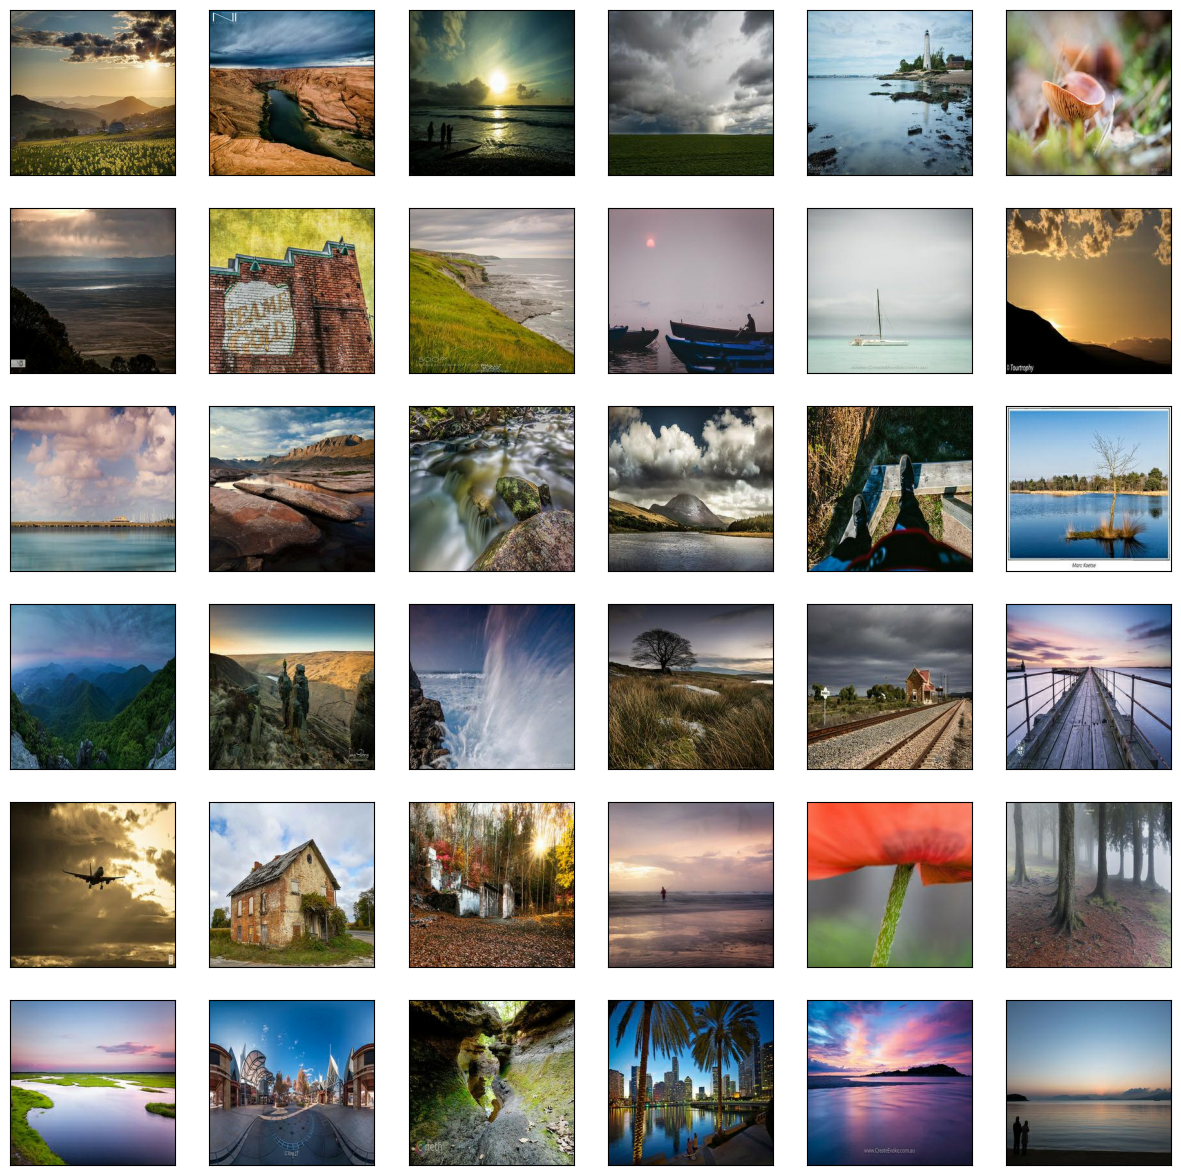

In [199]:
plot_photo(F_data)

In [202]:
gc.collect()

0

#  Model
###  GAN Components

In cycle gan, there are some common components in generators and discriminators. It is convenient to define those components as functions.

`FeatureMapBlock` is feature extractor which does not change image size. It is also used at the end of generator to improve quality of  generated images. `ContractingBlock` consists of **Conv2D**, **InstanceNormalization** and **activation fuction** which reduces image size just like typical CNN. `ResidualBlock` has two layers of **Conv2D** and **InstanceNormalization**. Original Input is skipped to the end of the block which minitage dead neuron problem. `ExandingBlock` consists of **Conv2DTranspose** which increases image size. It is followed by InstanceNormalization and activation function. For CycleGan model, InstanceNormalization is selected instead of BatchNormalization, because batch size = 1 in CycleGan training.


In [205]:
def FeatureMapBlock(channel, X, final = False):
    
    if final:
        X = layers.Conv2D(channel, kernel_size = 7, padding = "same", activation = "tanh")(X)
    
    else:
        X = layers.Conv2D(channel, kernel_size = 7, padding = "same")(X)
        X = tfa.layers.InstanceNormalization()(X)
        X = layers.LeakyReLU(alpha=0.2)(X)
        
    return X

In [206]:
def ContractingBlock(channel, X, relu = True, ksize = 3, use_bn = True):
    
    X =  layers.Conv2D(channel, kernel_size = ksize, strides = 2, padding = "same")(X)
    
    if use_bn:
        X = tfa.layers.InstanceNormalization()(X)
    
    if relu:
        X = layers.ReLU()(X)
    else:
        X = layers.LeakyReLU(alpha=0.2)(X)
        
    return X

In [207]:
def ResidualBlock(channel, X, relu = True):
    
    X_original = X # skip connection
    
    X = layers.Conv2D(channel, kernel_size = 3, padding = "same")(X)
    X = tfa.layers.InstanceNormalization()(X)
    
    if relu:
        X = layers.ReLU()(X)
    else:
        X = layers.LeakyReLU(alpha=0.2)(X)
        
    X = layers.Conv2D(channel, kernel_size = 3, padding = "same")(X)
    X = tfa.layers.InstanceNormalization()(X)
    
    
    return X + X_original
    

In [208]:
def ExpandingBlock(channel, X, ksize):
    
    X = layers.Conv2DTranspose(channel, kernel_size=ksize, strides=2, padding="SAME")(X)
    X = tfa.layers.InstanceNormalization()(X)
    X = layers.LeakyReLU(alpha=0.2)(X)
    
    return X

### Generator

Generator consists of following elements:

* FeatureMapBlock
* two or three ContractingBlocks
* several ResidualBlocks
* ExpandingBlocks
* Final Layer (FeatureMapBlock with `tanh`)

This structure is common for the both of generators AB and BA.

In [209]:
def Generator():
    Input =  layers.Input(shape=(256, 256, 3))
    
    channel = 64

    X = FeatureMapBlock(channel, Input, final = False) #
    KS = 5
    X = ContractingBlock(channel*2, X, False, KS)#128
    X = ContractingBlock(channel*4, X, False, KS)#64
    X = ContractingBlock(channel*8, X, False, KS)#32
    X = ContractingBlock(channel*8, X, False, KS)#16
    #X = ContractingBlock(channel*8, X, False, 3)#8
    #X = ContractingBlock(channel*8, X, False, 3)#4
    
    X = ResidualBlock(channel*8, X, False)
    X = ResidualBlock(channel*8, X, False)
    X = ResidualBlock(channel*8, X, False)
    
    KS = 5
    #X = ExpandingBlock(channel*8, X, 5)#8
    #X = ExpandingBlock(channel*8, X, 5)#16
    X = ExpandingBlock(channel*8, X, KS)#32
    X = ExpandingBlock(channel*4, X, KS)#64
    X = ExpandingBlock(channel*2, X, KS)#128
    X = ExpandingBlock(channel, X, KS)#256
    
    X =  FeatureMapBlock(3, X, final = True)
    
    model = Model(inputs = Input, outputs = X)
    
    return model
    

In [210]:
gen_AB = Generator()
gen_BA = Generator()
gen_AB.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_126 (Conv2D)            (None, 256, 256, 64  9472        ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 instance_normalization_144 (In  (None, 256, 256, 64  128        ['conv2d_126[0][0]']             
 stanceNormalization)           )                                                          

In [211]:
tf.keras.utils.plot_model(gen_AB)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


###  Discriminator

Discriminator consists of following elements:

* FeatureMapBlock
* Three ContractingBlocks
* Final Layer: Conv2D of size 1 without activation

This structure is common for both discriminator A and B.

In [212]:
def Discriminator():

    Input =  layers.Input(shape=(256, 256, 3))
    
    channel = 64
    
    X = FeatureMapBlock(channel, Input, False) #
    X = ContractingBlock(channel*2, X, False, 4) #128
    X = ContractingBlock(channel*4, X, False, 4) #64
    X = ContractingBlock(channel*4, X, False, 4) #32
    
    X = layers.Conv2D(1, kernel_size = 1, padding = "same")(X) #32
    
    model = Model(inputs = Input, outputs = X)
    
    return model

In [213]:
disc_A = Discriminator()
disc_B = Discriminator()
disc_A.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_150 (Conv2D)         (None, 256, 256, 64)      9472      
                                                                 
 instance_normalization_174   (None, 256, 256, 64)     128       
 (InstanceNormalization)                                         
                                                                 
 leaky_re_lu_144 (LeakyReLU)  (None, 256, 256, 64)     0         
                                                                 
 conv2d_151 (Conv2D)         (None, 128, 128, 128)     131200    
                                                                 
 instance_normalization_175   (None, 128, 128, 128)    256       
 (InstanceNormalization)                                  

# Loss
### Discriminator Loss

`get_disc_loss` calculate adversarial loss of a discriminator. It takes prediction (by discriminator) of real and fake images. It calculate loss based on adv_criterion. 

In [217]:
def get_disc_loss(real_pred, fake_pred, adv_criterion):
    
    ones_label = tf.ones_like(real_pred)
    zeros_label = tf.zeros_like(fake_pred)
    
    disc_loss = (adv_criterion(ones_label, real_pred) + adv_criterion(zeros_label, fake_pred))/2
    
    return disc_loss

### Generator Loss

There are three types of generator losses. First, `get_gen_adversarial_loss` calculate adv loss of a generator. It takes prediction (by discriminator) of fake images. True label is always 1 in this case. Then loss is calculated based on **adv_criterion**

`get_cycle_consistency_loss` compare cycled image with the original one. Typically MAE is selected as cycle_criterion. `get_identity_loss` has similar criterion. It calculates gap between original image with generated image. For example, if original is Monet, then we need to make sure that Monet image does not change after going through generator_Landscape_Monet (gen_BA). 

In [218]:
def get_gen_adversarial_loss(fake_pred, adv_criterion):
    
    #label is always one
    ones_label = tf.ones_like(fake_pred)
    
    loss = adv_criterion(ones_label, fake_pred)
    
    return loss
    

In [219]:
def get_cycle_consistency_loss(real_X, cycle_X, cycle_criterion):
    
    cycle_loss = cycle_criterion(real_X, cycle_X)
    
    return cycle_loss 

In [220]:
def get_identity_loss(real_X, identity_X, identity_criterion):
    
    identity_loss = identity_criterion(real_X, identity_X)

    return identity_loss #, identity_X


# Training Loop



**Optimizers**

Training cycle gan means training four models: generator AB and BA, discriminator A and B. Threfore, it needs four optimizers. 


In [221]:
optimizer_disc_A = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_disc_B = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_gen_AB = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_gen_BA = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

To monitor cycle gan training progress, losses will be stored in the following lists.

In [222]:
loss_discA = []
loss_discB = []

loss_gen_AB = []
loss_gen_BA = []


loss_gen_adv_AB = []
loss_gen_adv_BA = []

loss_gen_cycle_ABA = []
loss_gen_cycle_BAB = []

loss_gen_iden_AB = []
loss_gen_iden_BA = []

**Loss functions**

For adversarial loss, BCE or MSE are selected. For other criterion, MAE is the choice. 

In [223]:
BCE_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss =  tf.keras.losses.MeanAbsoluteError()

In [224]:
adv_loss_function = BCE_loss

`train_CycleGan` trains discriminator and generator separately. To keep balance between generator and discriminator, it does not train disciminator when loss is less than threshold. After training discriminators, it traing generators.

`Train_OneEpoch` function contains `train_CycleGan` in `for loop`. It reads Monet image and Landscape image, then input those images into training. It also has horizontal flip of Monet image as data augmentation, because there are only 300 of Monet images. Everytime of training, it randomly select Monet and Landscape. Thus, combination of two images changes by every training routine. 

In [225]:
@tf.function
def train_CycleGan(real_A, real_B):
    
    lambda_cycle = 10
    lambda_identity = 2
    lambda_adv = 1
    
    # Threshold of training discriminator. It skips training discriminator when loss <  threshold
    disc_train_threshold = 0.35
    
    
    with tf.GradientTape() as tape:
    
        #fake 
        fake_A =  gen_BA(real_B)
        
        #pred by disc
        real_A_pred = disc_A(real_A)
        fake_A_pred = disc_A(fake_A)
        
        #disc loss    
        disc_loss_A = get_disc_loss(real_A_pred, fake_A_pred, adv_loss_function)### MSE or BCE
        #loss_discA.append(disc_loss_A)
        
        
    #if disc_loss_A > disc_train_threshold:

    gradients = tape.gradient(disc_loss_A, disc_A.trainable_weights)
    optimizer_disc_A.apply_gradients(zip(gradients, disc_A.trainable_weights))
    
    
    with tf.GradientTape() as tape:
    
        #fake 
        fake_B = gen_AB(real_A)
        
        #pred by disc
        real_B_pred = disc_B(real_B)
        fake_B_pred = disc_B(fake_B)
        
        #disc loss    
        disc_loss_B = get_disc_loss(real_B_pred, fake_B_pred, adv_loss_function)### MSE or BCE
        #loss_discB.append(disc_loss_B)
        
    #if disc_loss_B > disc_train_threshold:

        
    gradients = tape.gradient(disc_loss_B, disc_B.trainable_weights)    
    optimizer_disc_B.apply_gradients(zip(gradients, disc_B.trainable_weights))
        

    with tf.GradientTape(persistent=True) as tape:
        
        #fake 
        fake_A =  gen_BA(real_B)
        fake_B = gen_AB(real_A)
        
        #cycle
        cycle_A = gen_BA(fake_B)
        cycle_B = gen_AB(fake_A)

        #identity 
        iden_B = gen_AB(real_B)
        iden_A = gen_BA(real_A)

        #pred by disc
        fake_B_pred = disc_B(fake_B)
        fake_A_pred = disc_A(fake_A)

        
        #gen loss
        gen_adversarial_loss_AB = get_gen_adversarial_loss(fake_B_pred, adv_loss_function)### MSE or BCE
        gen_adversarial_loss_BA = get_gen_adversarial_loss(fake_A_pred, adv_loss_function)### MSE or BCE
        
        #loss_gen_adv_AB.append(gen_adversarial_loss_AB)
        #loss_gen_adv_BA.append(gen_adversarial_loss_BA)

        #cycle loss
        cycle_loss_A = get_cycle_consistency_loss(real_A, cycle_A, MAE_loss)
        cycle_loss_B = get_cycle_consistency_loss(real_B, cycle_B, MAE_loss) 
        total_cycle_loss = cycle_loss_A + cycle_loss_B
        
        #loss_gen_cycle_ABA.append(cycle_loss_A)
        #loss_gen_cycle_BAB.append(cycle_loss_B)
        
        #identity loss
        identity_loss_AB = get_identity_loss(real_B, iden_B, MAE_loss)
        identity_loss_BA = get_identity_loss(real_A, iden_A, MAE_loss)
        
        #loss_gen_iden_AB.append(identity_loss_AB)
        #loss_gen_iden_BA.append(identity_loss_BA)

        #gen loss
        #gen_loss = gen_adversarial_loss*lambda_adv + cycle_loss*lambda_cycle + identity_loss*lambda_identity
        gen_loss_AB = gen_adversarial_loss_AB*lambda_adv + total_cycle_loss*lambda_cycle + identity_loss_AB*lambda_identity
        gen_loss_BA = gen_adversarial_loss_BA*lambda_adv + total_cycle_loss*lambda_cycle + identity_loss_BA*lambda_identity
        #loss_gen_AB.append(gen_loss_AB)
        #loss_gen_BA.append(gen_loss_BA)
    
    gradients = tape.gradient(gen_loss_AB, gen_AB.trainable_weights)
    optimizer_gen_AB.apply_gradients(zip(gradients, gen_AB.trainable_weights))
    
    gradients = tape.gradient(gen_loss_BA, gen_BA.trainable_weights)
    optimizer_gen_BA.apply_gradients(zip(gradients, gen_BA.trainable_weights))    

    del tape
    gc.collect()
    
    #return disc_loss_A, disc_loss_B, total_cycle_loss, identity_loss_AB, identity_loss_BA, gen_loss_AB, gen_loss_BA

In [226]:
def read_img(dir_name, file_name, convert = False):
    
    img = cv2.cvtColor(cv2.imread(dir_name + file_name), cv2.COLOR_BGR2RGB)
    
    if convert:
        img = img/(255/2) - 1
    
    return img

In [227]:
def Train_OneEpoch(EPOCH):
    
    time1 = time.time()
    print("EPOCH ", EPOCH)
    count = 0

    np.random.seed(EPOCH)

    m_idx = np.arange(n1)
    np.random.shuffle(m_idx)

    f_idx = np.arange(len(files_photo))
    np.random.shuffle(f_idx)


    for i in range(n1):
        F_data = read_img(dir_photo, files_photo[f_idx[i]], convert = True)

        M_data2 = M_data[m_idx[i]]

        #Horizontal Flip of Monet image
        if np.random.rand(1)[0] > 0.5:
            train_CycleGan(M_data2[:,::-1,:].reshape(1,256,256,3), F_data.reshape(1,256,256,3))
        else:
            train_CycleGan(M_data2.reshape(1,256,256,3), F_data.reshape(1,256,256,3))


        if (i+1) % 100 == 0:
            print(i+1)



    time2 = time.time()

    time3 = np.round(time2 - time1)

    print("time ", time3, "sec")
    

`check_output` visualize training progress after each epoch. It shows original Landscape image, converted image, cycled image, and identity image.

In [228]:
def check_output(EPOCH, plot_line, plot_all = False):
    
    real_A = M_data[0:36]
    real_B = F_data[0:36]

    fake_B = gen_AB(real_A)
    fake_A = gen_BA(real_B)

    cycle_A = gen_BA(fake_B)
    identity_A = gen_BA(real_A)

    cycle_B = gen_AB(fake_A)
    identity_B = gen_AB(real_B)


    tag = "_" + str(EPOCH)


    #np.save("real_A", convert_image_size(real_A))
    np.save("real_B", convert_image_size(real_B))

    #np.save("fake_B" +tag, convert_image_size(fake_B))
    #np.save("cycle_A" +tag, convert_image_size(cycle_A))
    #np.save("identity_A" +tag, convert_image_size(identity_A))
    
    np.save("fake_A" +tag, convert_image_size(fake_A))
    np.save("cycle_B" +tag, convert_image_size(cycle_B))
    np.save("identity_B" +tag, convert_image_size(identity_B))

    tag = ", epoch " + str(EPOCH)

    if plot_all:
        #plot_photo(fake_B)
        plot_photo(fake_A)
        

    if plot_line:

        #plot_OneLine(real_A, "real_A")
        #plot_OneLine(fake_B, "fake_B " + tag)
        #plot_OneLine(cycle_A, "cycle_A " + tag)
        #plot_OneLine(identity_A, "identity_A " + tag)

        plot_OneLine(real_B, "real_B")
        plot_OneLine(fake_A, "fake_A " + tag)
        plot_OneLine(cycle_B, "cycle_B " + tag)
        plot_OneLine(identity_B, "identity_B " + tag)          
            
    

In [229]:
def Train_Loop(EPOCH, EPOCH_prev):
    
    plot_line = True
    
    for i in range(EPOCH):
    
        Train_OneEpoch(i + EPOCH_prev)
        
        plot_line = False
        if (i + EPOCH_prev) % 5 == 0:   
            plot_line = True
            
            check_output(i + EPOCH_prev, plot_line, False)


# 6. Training and validation of Cycle GAN

During training, CycleGAN is validated visually by plotting fake image, cycled image, and identity image from perspective of image structure, color, texture, etc. Furthermore, train loss is plotted to make sure the mode collapse (over fitting) does not occour.

In [230]:
N_EPOCH = 1

In [ ]:
Train_Loop(N_EPOCH, N_EPOCH)

In [ ]:
gen_AB.save_weights("gen_AB/ckpt1")
gen_BA.save_weights("gen_BA/ckpt2")

In [ ]:
disc_A.save_weights("disc_A/ckpt3")
disc_B.save_weights("disc_B/ckpt4")

### Training Loss

In [ ]:
def plot_loss():
    
    fig, ax = plt.subplots(3, figsize = (10, 12))

    #cut off the first 40 train loss
    start = 0
    ax[0].plot(loss_discA[start:], label  ="disc_A", alpha = 0.7, lw = 0.6)
    ax[0].plot(loss_discB[start:], label = "disc_B", alpha = 0.7, lw = 0.6)
    ax[0].plot(loss_gen_adv_AB[start:], label = "gen_AB", alpha = 0.7, lw = 0.6)
    ax[0].plot(loss_gen_adv_BA[start:], label = "gen_BA", alpha = 0.7, lw = 0.6)
    ax[0].set_title("Adversarial Loss")
    ax[0].set_ylim(0,2)


    #ax[1].plot(np.array(loss_gen_adv), label = "adv", alpha = 0.8)
    ax[1].plot(loss_gen_cycle_ABA[start:], label  ="cycle_ABA", alpha = 0.7, lw = 0.6)
    ax[1].plot(loss_gen_cycle_BAB[start:], label  ="cycle_BAB", alpha = 0.7, lw = 0.6)
    ax[1].plot(loss_gen_iden_AB[start:], label = "identity_AB", alpha = 0.7, lw = 0.6)
    ax[1].plot(loss_gen_iden_BA[start:], label = "identity_BA", alpha = 0.7, lw = 0.6)
    ax[1].set_title("Generator Loss")

    ax[2].plot(loss_gen_AB[start:], label = "gen_AB", alpha = 0.7, lw = 0.6)
    ax[2].plot(loss_gen_BA[start:], label = "gen_BA", alpha = 0.7, lw = 0.6)
    ax[2].set_title("Generator Loss (total)")

    for i in range(3):
        ax[i].grid()
        ax[i].legend()